Project: Guild line:
- 1. pick 20 to put in portfolio
- 2. create 3 portfolio selections
    - a. Equally weighted
    - b. Min variance
    - c. Max Sharpe
- 3. Plot Markowiz Efficient Frontier and decide you most favorite portfolio
    

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import gurobipy as gp
from gurobipy import GRB

In [2]:
# load stock data 
stocks = ['AAPL','TWTR','META','LMT','TSLA','MSFT','OXY','BP',
 'XOM','BAC','JPM','C','COF',
 'F','GM','HMC','TGT','TTM','RACE',
 'COST']


len(stocks)
data = yf.download(stocks, period='3mo')

[*********************100%***********************]  20 of 20 completed


In [3]:
data['Adj Close'].isnull().sum()

AAPL    0
BAC     0
BP      0
C       0
COF     0
COST    0
F       0
GM      0
HMC     0
JPM     0
LMT     0
META    0
MSFT    0
OXY     0
RACE    0
TGT     0
TSLA    0
TTM     0
TWTR    0
XOM     0
dtype: int64

In [4]:
# calcuate the stock's log return
returns = data['Adj Close']/data['Adj Close'].shift(1)

log_ret = np.log(returns.iloc[1:])

print(log_ret.shape)
log_ret.head()

(63, 20)


AAPL       BAC        BP         C       COF      COST  \
Date                                                                     
2022-07-05  0.018753 -0.010191 -0.040778 -0.005563 -0.001499  0.005133   
2022-07-06  0.009561 -0.008358 -0.015965 -0.009918 -0.005830  0.008951   
2022-07-07  0.023716  0.028010  0.038904  0.016760  0.026062  0.004658   
2022-07-08  0.004704 -0.002199  0.002158 -0.002347 -0.002115  0.013227   
2022-07-11 -0.014868 -0.010435 -0.013744 -0.013547 -0.013347 -0.005278   

                   F        GM       HMC       JPM       LMT      META  \
Date                                                                     
2022-07-05 -0.010657  0.005576 -0.025095 -0.003811 -0.043057  0.049733   
2022-07-06 -0.012579 -0.034573 -0.008934 -0.006503  0.025300  0.009350   
2022-07-07  0.051971  0.043492  0.028646  0.024978 -0.008726  0.014154   
2022-07-08 -0.002578 -0.010774  0.003317 -0.003143 -0.004368 -0.007637   
2022-07-11 -0.028810 -0.045592 -0.009983 -0.013203 -0.003050 -0.047948   

                MSFT       OXY      RACE       TGT      TSLA       TTM  \
Date                                                                     
2022-07-05  0.012519 -0.022251  0.010796  0.023119  0.025215 -0.006862   
2022-07-06  0.012702  0.000000 -0.000895 -0.006196 -0.005737  0.010655   
2022-07-07  0.008193  0.039149  0.014436  0.034946  0.053805  0.047311   
2022-07-08 -0.002761 -0.013100  0.005489 -0.013224  0.025117  0.007194   
2022-07-11 -0.011839 -0.019137 -0.015353 -0.010870 -0.067722 -0.023206   

                TWTR       XOM  
Date                            
2022-07-05  0.003916 -0.031797  
2022-07-06 -0.004439 -0.018205  
2022-07-07  0.015065  0.031441  
2022-07-08 -0.052393  0.001628  
2022-07-11 -0.119925 -0.005125

In [5]:
# calculate co-variance matrix use log return of stock
sigma = log_ret.cov()

sigma

AAPL       BAC        BP         C       COF      COST         F  \
AAPL  0.000376  0.000191  0.000098  0.000201  0.000257  0.000213  0.000297   
BAC   0.000191  0.000354  0.000191  0.000385  0.000359  0.000136  0.000359   
BP    0.000098  0.000191  0.000475  0.000227  0.000227  0.000069  0.000222   
C     0.000201  0.000385  0.000227  0.000512  0.000388  0.000160  0.000416   
COF   0.000257  0.000359  0.000227  0.000388  0.000563  0.000198  0.000468   
COST  0.000213  0.000136  0.000069  0.000160  0.000198  0.000280  0.000281   
F     0.000297  0.000359  0.000222  0.000416  0.000468  0.000281  0.000994   
GM    0.000319  0.000325  0.000234  0.000373  0.000409  0.000253  0.000705   
HMC   0.000168  0.000191  0.000148  0.000215  0.000247  0.000117  0.000348   
JPM   0.000172  0.000296  0.000156  0.000317  0.000300  0.000121  0.000321   
LMT   0.000096  0.000069  0.000084  0.000068  0.000068  0.000080  0.000117   
META  0.000370  0.000353  0.000202  0.000432  0.000564  0.000246  0.000488   
MSFT  0.000268  0.000184  0.000117  0.000210  0.000261  0.000223  0.000300   
OXY   0.000070  0.000159  0.000415  0.000200  0.000271  0.000079  0.000243   
RACE  0.000227  0.000177  0.000120  0.000215  0.000256  0.000189  0.000387   
TGT   0.000228  0.000246  0.000085  0.000246  0.000372  0.000220  0.000476   
TSLA  0.000401  0.000226  0.000169  0.000229  0.000332  0.000304  0.000534   
TTM   0.000199  0.000196  0.000134  0.000228  0.000257  0.000168  0.000397   
TWTR  0.000098  0.000151  0.000053  0.000186  0.000155  0.000063  0.000240   
XOM   0.000099  0.000161  0.000387  0.000189  0.000221  0.000078  0.000241   

            GM       HMC       JPM       LMT      META      MSFT       OXY  \
AAPL  0.000319  0.000168  0.000172  0.000096  0.000370  0.000268  0.000070   
BAC   0.000325  0.000191  0.000296  0.000069  0.000353  0.000184  0.000159   
BP    0.000234  0.000148  0.000156  0.000084  0.000202  0.000117  0.000415   
C     0.000373  0.000215  0.000317  0.000068  0.000432  0.000210  0.000200   
COF   0.000409  0.000247  0.000300  0.000068  0.000564  0.000261  0.000271   
COST  0.000253  0.000117  0.000121  0.000080  0.000246  0.000223  0.000079   
F     0.000705  0.000348  0.000321  0.000117  0.000488  0.000300  0.000243   
GM    0.000704  0.000316  0.000291  0.000088  0.000484  0.000268  0.000285   
HMC   0.000316  0.000306  0.000160  0.000070  0.000257  0.000146  0.000188   
JPM   0.000291  0.000160  0.000278  0.000067  0.000325  0.000170  0.000113   
LMT   0.000088  0.000070  0.000067  0.000165  0.000076  0.000099  0.000093   
META  0.000484  0.000257  0.000325  0.000076  0.001021  0.000397  0.000103   
MSFT  0.000268  0.000146  0.000170  0.000099  0.000397  0.000342  0.000118   
OXY   0.000285  0.000188  0.000113  0.000093  0.000103  0.000118  0.000948   
RACE  0.000314  0.000185  0.000160  0.000061  0.000303  0.000227  0.000121   
TGT   0.000359  0.000176  0.000230  0.000066  0.000418  0.000258  0.000061   
TSLA  0.000505  0.000242  0.000202  0.000115  0.000498  0.000335  0.000105   
TTM   0.000297  0.000245  0.000163  0.000093  0.000325  0.000167  0.000127   
TWTR  0.000302  0.000130  0.000161  0.000002  0.000267  0.000102  0.000044   
XOM   0.000226  0.000163  0.000139  0.000077  0.000117  0.000115  0.000532   

          RACE       TGT      TSLA       TTM      TWTR       XOM  
AAPL  0.000227  0.000228  0.000401  0.000199  0.000098  0.000099  
BAC   0.000177  0.000246  0.000226  0.000196  0.000151  0.000161  
BP    0.000120  0.000085  0.000169  0.000134  0.000053  0.000387  
C     0.000215  0.000246  0.000229  0.000228  0.000186  0.000189  
COF   0.000256  0.000372  0.000332  0.000257  0.000155  0.000221  
COST  0.000189  0.000220  0.000304  0.000168  0.000063  0.000078  
F     0.000387  0.000476  0.000534  0.000397  0.000240  0.000241  
GM    0.000314  0.000359  0.000505  0.000297  0.000302  0.000226  
HMC   0.000185  0.000176  0.000242  0.000245  0.000130  0.000163  
JPM   0.000160  0.000230  0.000202  0.000163  0.000161  0.0001

In [6]:
# calculate mean return of each stock
mean_ret = log_ret.mean()
# calcuate volatility of each stock
volatility = log_ret.std()

stock_matrix = pd.DataFrame({'mean log return':mean_ret,
                             'log return volatility':volatility})

stock_matrix

mean log return  log return volatility
AAPL        -0.000062               0.019379
BAC         -0.000595               0.018809
BP           0.000337               0.021788
C           -0.001711               0.022617
COF         -0.002252               0.023731
COST        -0.000420               0.016741
F           -0.000012               0.031534
GM          -0.000013               0.026525
HMC         -0.001818               0.017484
JPM         -0.001248               0.016668
LMT         -0.001726               0.012830
META        -0.002620               0.031955
MSFT        -0.001688               0.018506
OXY          0.000295               0.030790
RACE        -0.000250               0.017428
TGT          0.000755               0.021632
TSLA         0.002453               0.030840
TTM         -0.001294               0.022689
TWTR         0.002173               0.027503
XOM          0.000110               0.021212

Text(0.5, 1.0, 'Trending of the selected stock')

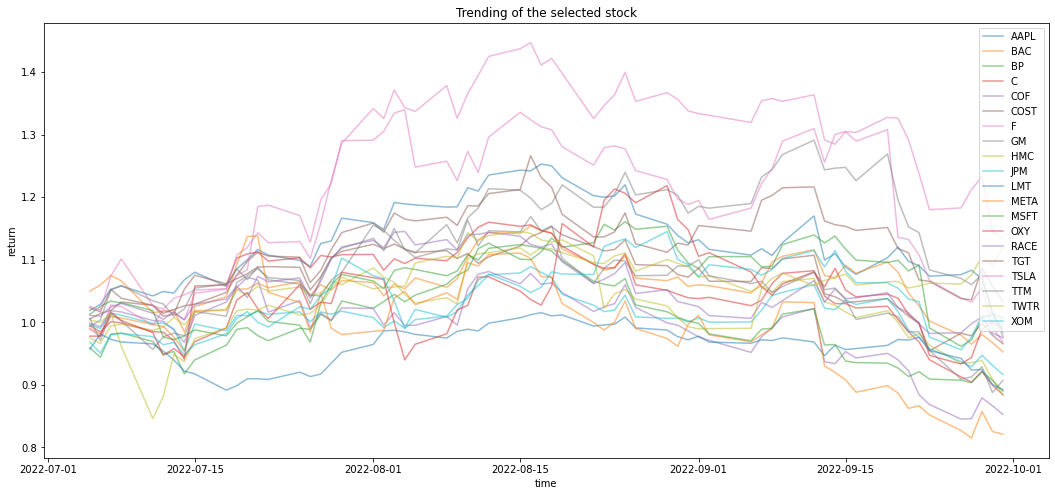

In [8]:
# plot the trend of the selected stock
plt.figure(figsize=(18,8))
for s in log_ret.columns:
    plt.plot((log_ret[s] + 1).cumprod(),
             label = s,
             alpha = 0.5)
    
plt.legend()
plt.xlabel('time')
plt.ylabel('return')
plt.title('Trending of the selected stock')

# Equally Weight Portifolio

In [10]:
# generate equally weight
w = [1/len(stocks) for w in range(len(stocks))]

w

[0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05]

In [11]:
# compute variance with Equally Weighted Portfolio
equl_weigh_var = w @ sigma @ w

print('Variance for Equally Weighted Portfolio:',equl_weigh_var)

Variance for Equally Weighted Portfolio: 0.00024062051532852647


In [12]:
# compute expect with Equally Weighted Portfolio
exp_ret = stock_matrix['mean log return'] @ w

print('Expected Return for Equally Weighted Portfolio:',exp_ret)

Expected Return for Equally Weighted Portfolio: -0.0004791765520831103


In [13]:
# compute Sharpe ratio for Equally Weighted Portfolio
SR = exp_ret/np.sqrt(equl_weigh_var)

print('Sharpe ratio for Equally Weighted Portfolio:',SR)

Sharpe ratio for Equally Weighted Portfolio: -0.03089080542579892


In [14]:
# compute Equally Weighted Portfolio return
equl_weigh_ret =  0 
for s,weight in zip(log_ret.columns,w):
    equl_weigh_ret += log_ret[s] * weight
    
equl_weigh_ret.head()

Date
2022-07-05   -0.002340
2022-07-06   -0.003081
2022-07-07    0.026849
2022-07-08   -0.002690
2022-07-11   -0.024649
Name: AAPL, dtype: float64

Text(0.5, 1.0, 'Equally Weighted Portfolio Return vs Selected stock Return')

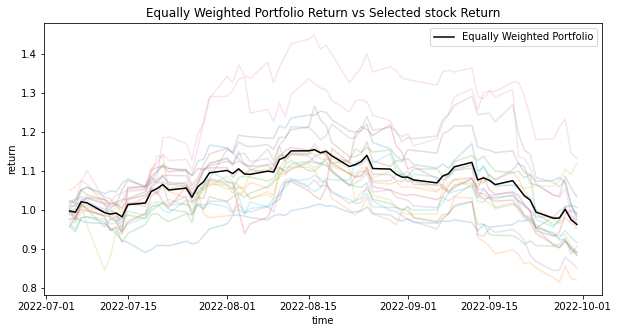

In [15]:
plt.figure(figsize=(10,5))
for s in log_ret.columns:
    plt.plot((log_ret[s] + 1).cumprod(),
             alpha = 0.2)

plt.plot((equl_weigh_ret + 1).cumprod(),
          color = 'black',
          label = 'Equally Weighted Portfolio')

plt.legend()
plt.xlabel('time')
plt.ylabel('return')
plt.title('Equally Weighted Portfolio Return vs Selected stock Return')

In [16]:
# display holding period return for Equally Weighted Portfolio
(equl_weigh_ret + 1).cumprod().tail(1)

Date
2022-09-30    0.963029
Name: AAPL, dtype: float64

# Mininum Variance Portifolio

In [17]:
# define GUROBI model
model = gp.Model('Min Variance')

model

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04


<gurobi.Model Continuous instance Min Variance: 0 constrs, 0 vars, No parameter changes>

In [18]:
# define variable
x = model.addMVar(len(stocks))

x

<(20,) matrix variable>

In [19]:
# add constraint
model.addConstr(x.sum() == 1, 'budget')

<(1,) matrix constraint>

In [20]:
# define objective
variance = x @ np.array(sigma) @ x
# set model objective
model.setObjective(variance, GRB.MINIMIZE)

In [21]:
# optimize model
model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 20 columns and 20 nonzeros
Model fingerprint: 0x776ea580
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [9e-06, 3e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 20 columns, 20 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 1.900e+02
 Factor NZ  : 2.100e+02
 Factor Ops : 2.870e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.17159215e+05 -2.17159215e+05  9.50e+03 6.83e-06  1.00e+06     0s
   1   1.65101102e+05 -1.65112486e+05  1.16e+03 8.3

In [22]:
# display the weight with Mininum Variance Portifolio
Min_Var_Port_w = x.X

print(np.sum(Min_Var_Port_w))
Min_Var_Port_w

0.9999999999999999


array([5.14424293e-07, 2.93248132e-06, 7.99803062e-03, 7.59751757e-07,
       3.14843168e-07, 1.34037853e-01, 7.49550296e-08, 1.05352387e-07,
       5.72133838e-02, 7.28301849e-02, 5.19219453e-01, 4.17052624e-07,
       4.28150649e-07, 3.93220386e-07, 3.47307695e-02, 7.09031628e-07,
       1.18766134e-07, 6.01014595e-06, 1.01953762e-01, 7.20037851e-02])

In [23]:
# display the Mininum Variance with Mininum Variance Portifolio
min_var = model.ObjVal

min_var

0.00011356475295996029

In [24]:
# display the Expected Return with Mininum Variance Portifolio
exp_ret_at_minVar = stock_matrix['mean log return'] @ Min_Var_Port_w

exp_ret_at_minVar

-0.0009238824375915515

In [25]:
# compute Sharpe ratio for Mininum Variance Portifolio
SR_min = exp_ret_at_minVar/np.sqrt(min_var)

print('Sharpe ratio for Mininum Variance Portifolio:',SR_min)

Sharpe ratio for Mininum Variance Portifolio: -0.08669517573573798


In [26]:
# compute Mininum Variance Portifolio return
min_var_ret =  0 
for s,weight in zip(log_ret.columns,Min_Var_Port_w):
    min_var_ret += log_ret[s] * weight
    
min_var_ret.head()

Date
2022-07-05   -0.025223
2022-07-06    0.011429
2022-07-07    0.004165
2022-07-08   -0.005551
2022-07-11   -0.017063
Name: AAPL, dtype: float64

Text(0.5, 1.0, 'Mininum Variance Portifolio Return vs Selected stock Return')

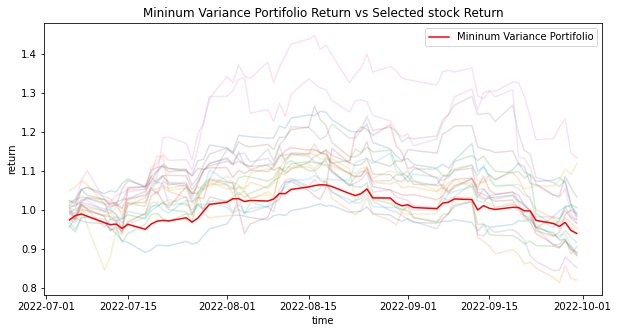

In [27]:
plt.figure(figsize=(10,5))
for s in log_ret.columns:
    plt.plot((log_ret[s] + 1).cumprod(),
             alpha = 0.2)

plt.plot((min_var_ret + 1).cumprod(),
          color = 'red',
          label = 'Mininum Variance Portifolio')

plt.legend()
plt.xlabel('time')
plt.ylabel('return')
plt.title('Mininum Variance Portifolio Return vs Selected stock Return')

In [28]:
# compute holding period return for Mininum Variance Portifolio
(min_var_ret + 1).cumprod().tail(1)

Date
2022-09-30    0.940098
Name: AAPL, dtype: float64

# Max Sharpe Ratio Portfoilo (Monte Carlo)

In [29]:
# initialize code that can generate random weight
# the sum of w have to equal 1
def get_weight(n):
    w = []
    nw = n- 1
    low = 0
    high = 1
    for i in range(nw):
        w.append(np.random.uniform(low,high,1))
        high = 1 - np.sum(w)
    w.append(1-sum(w))

    weight = [np.float(i) for i in w]
    return np.array(weight)[::-1]

print(np.sum(get_weight(20)))
print(get_weight(20).shape)
get_weight(20)

1.0
(20,)


C:\Users\86130\AppData\Local\Temp/ipykernel_17972/2370275164.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  weight = [np.float(i) for i in w]


array([6.65529853e-10, 5.23478925e-10, 8.18701429e-08, 8.17087046e-08,
       3.84436765e-07, 2.95111959e-07, 1.98099894e-06, 2.97206108e-06,
       4.31004171e-06, 3.69425765e-07, 2.23293399e-05, 6.74692811e-06,
       8.72757176e-04, 5.36013748e-05, 6.51654344e-04, 1.26128150e-03,
       9.87773962e-04, 6.01421376e-03, 6.22448880e-04, 9.89496716e-01])

In [30]:
# set n = number of experiments
n = 1000000
# create [] to store data
weight = []
ret = []
vol = []
sharpe = []
for i in range(n):
    # initialize code that can generate random weight
    w = get_weight(20)
    weight.append(w)
    # return
    R = stock_matrix['mean log return'] @ w
    ret.append(R)
    # volatility
    V = np.sqrt(w @ sigma @ w)
    vol.append(V)
    # sharpe ratio
    S = R/V
    sharpe.append(S)

C:\Users\86130\AppData\Local\Temp/ipykernel_17972/2370275164.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  weight = [np.float(i) for i in w]


In [31]:
d = {'sharpe':sharpe,
     'ret':ret,
     'vol':vol,
     'weight':weight}

df = pd.DataFrame(d)

print(df.shape)
df.head()

(1000000, 4)


sharpe       ret       vol  \
0  0.036595  0.000585  0.015993   
1  0.063298  0.001129  0.017841   
2  0.063841  0.001048  0.016419   
3  0.071814  0.001422  0.019795   
4 -0.009187 -0.000143  0.015520   

                                              weight  
0  [6.1900153891514265e-09, 1.4610125837281331e-0...  
1  [4.6311347978722495e-08, 2.505078564487315e-07...  
2  [4.170658596258647e-09, 2.7828823773098445e-09...  
3  [2.24309837371095e-09, 3.6994449904308473e-11,...  
4  [1.208741196023766e-08, 1.5153252100746857e-07...

In [32]:
df['sharpe'].max()

0.09745287125191181

In [33]:
# show the best sharpe ratio result by Monte Carlo
df_top = df.sort_values(by=['sharpe'],
                        ascending=False).head(1)

df_top

sharpe      ret       vol  \
596241  0.097453  0.00221  0.022676   

                                                   weight  
596241  [1.3991265923607443e-09, 3.4224415883690457e-1...

In [34]:
# show the best weight
Max_sharpe_w = df_top.weight.values[0]

print(sum(Max_sharpe_w))
pd.DataFrame(Max_sharpe_w).T

1.0


0             1             2             3             4   \
0  1.399127e-09  3.422442e-10  1.650065e-09  7.302561e-09  1.059504e-07   

             5             6             7         8         9         10  \
0  2.419936e-08  5.863370e-09  1.895400e-07  0.000003  0.000007  0.000012   

         11        12        13        14        15        16        17  \
0  0.001146  0.000159  0.000531  0.003682  0.015755  0.422949  0.003258   

         18        19  
0  0.536871  0.015627

#### Here is a screen shot of best weight find by excel solver
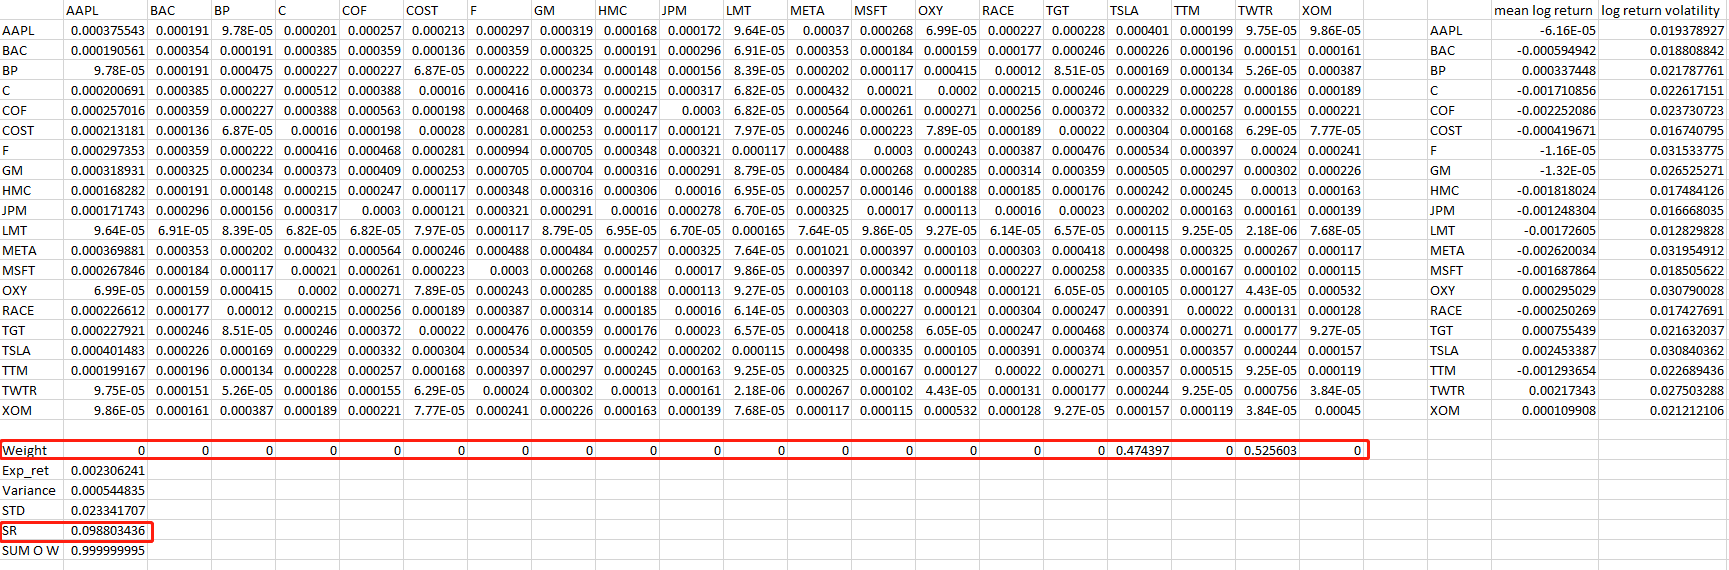

In [35]:
# compute Max Sharpe ratio Portifolio return
max_sharpe_ret =  0 
for s,weight in zip(log_ret.columns,Max_sharpe_w):
    max_sharpe_ret += log_ret[s] * weight
    
max_sharpe_ret.head()

Date
2022-07-05    0.012698
2022-07-06   -0.005148
2022-07-07    0.032133
2022-07-08   -0.017660
2022-07-11   -0.093478
Name: AAPL, dtype: float64

Text(0.5, 1.0, 'Max Sharpe Portifolio Return vs Selected stock Return')

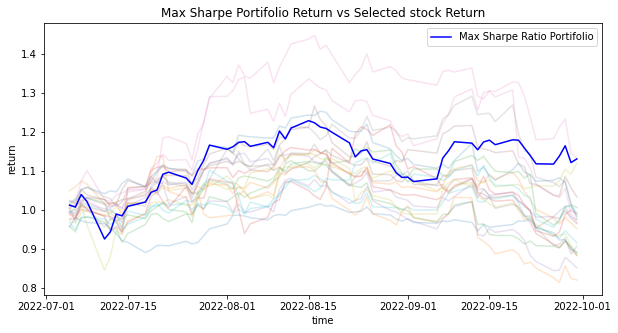

In [36]:
plt.figure(figsize=(10,5))
for s in log_ret.columns:
    plt.plot((log_ret[s] + 1).cumprod(),
             alpha = 0.2)

plt.plot((max_sharpe_ret + 1).cumprod(),
          color = 'blue',
          label = 'Max Sharpe Ratio Portifolio')

plt.legend()
plt.xlabel('time')
plt.ylabel('return')
plt.title('Max Sharpe Portifolio Return vs Selected stock Return')

In [37]:
# compute holding period return for Max Sharpe Portifolio
(max_sharpe_ret + 1).cumprod().tail(1)

Date
2022-09-30    1.130842
Name: AAPL, dtype: float64

# Plot Markowiz Efficient Frontier with selected stock
- Here we use the gurobo model we defined before to plot Efficient Frontier


In [38]:
# get two retrun
ret_LHS =  np.array(mean_ret) @ x
ret_RHS = np.array(mean_ret) @ x.X

In [39]:
target = model.addConstr(ret_LHS == ret_RHS, 'target')

target

<(1,) matrix constraint>

In [40]:
# retrun-range = min_mean return ~ max_mean return
return_range = np.linspace(mean_ret.min(), mean_ret.max(), 25)

return_range

array([-2.62003448e-03, -2.40864193e-03, -2.19724938e-03, -1.98585683e-03,
       -1.77446428e-03, -1.56307173e-03, -1.35167919e-03, -1.14028664e-03,
       -9.28894089e-04, -7.17501541e-04, -5.06108992e-04, -2.94716444e-04,
       -8.33238959e-05,  1.28068652e-04,  3.39461201e-04,  5.50853749e-04,
        7.62246297e-04,  9.73638846e-04,  1.18503139e-03,  1.39642394e-03,
        1.60781649e-03,  1.81920904e-03,  2.03060159e-03,  2.24199414e-03,
        2.45338668e-03])

In [41]:
frontier = []
for r in return_range:
    # change right hand side of target constraint to return in return range
    target[0].rhs = r
    model.optimize()
    frontier.append(np.sqrt(model.ObjVal))

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 20 columns and 40 nonzeros
Model fingerprint: 0x88f0d4ec
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-05, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [9e-06, 3e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-03, 1e+00]
Presolve time: 0.00s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.17038787e+05 -2.17038787e+05  8.75e+03 8.74e-03  1.00e+06     0s
   1   1.51478076e+05 -1.51492891e+05  1.17e+03 1.1

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.17041933e+05 -2.17041933e+05  8.75e+03 8.51e-03  1.00e+06     0s
   1   1.51478513e+05 -1.51492281e+05  1.17e+03 1.13e-03  1.46e+05     0s
   2   5.98573546e+02 -6.19437677e+02  4.95e+01 4.82e-05  6.95e+03     0s
   3   2.43213791e-03 -2.16895324e+01  6.34e-02 6.17e-08  9.98e+00     0s
   4   4.46216763e-04 -1.23496821e+01  1.27e-03 1.24e-09  7.65e-01     0s
   5   4.54426336e-04 -5.20379934e-01  1.27e-09 1.24e-15  2.60e-02     0s
   6   4.54100219e-04 -7.56923482e-04  1.69e-12 1.63e-18  6.06e-05     0s
   7   3.39602909e-04 -1.27470771e-04  3.72e-13 8.67e-19  2.34e-05     0s
   8   1.83566386e-04 -8.84916560e-05  9.54e-17 5.55e-17  1.36e-05     0s
   9   1.52506344e-04  1.04167035e-04  2.78e-17 4.86e-17  2.42e-06     0s
  10   1.39805690e-04  1.27931652e-04  3.73e-16 1.04e-17  5.94e-07     0s
  11   1.36358526e-04  1.34597440e-04  4.01e-16 1.04e-17  8.81e-08     0s
  12   1.35121278e-04  1.34901830e-04 

   4   3.28471369e-04 -1.59230294e+01  5.03e-08 4.76e-14  7.96e-01     0s
   5   3.28464750e-04 -1.62039866e-02  1.93e-12 1.11e-12  8.27e-04     0s
   6   3.23405897e-04 -3.36967808e-04  6.40e-14 3.68e-14  3.30e-05     0s
   7   1.58380520e-04 -2.71238766e-04  3.47e-18 1.39e-17  2.15e-05     0s
   8   1.33225756e-04  8.96718379e-05  1.08e-18 1.58e-17  2.18e-06     0s
   9   1.17981487e-04  1.11710461e-04  2.18e-16 1.73e-18  3.14e-07     0s
  10   1.13985087e-04  1.13226933e-04  5.03e-17 2.63e-18  3.79e-08     0s
  11   1.13568087e-04  1.13559533e-04  3.47e-17 2.60e-18  4.28e-10     0s

Barrier solved model in 11 iterations and 0.02 seconds (0.00 work units)
Optimal objective 1.13568087e-04

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 20 columns and 40 nonzeros
Model fingerprint: 0x1abd43f0
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range    

  11   1.33074233e-04  1.33068740e-04  2.79e-16 1.13e-17  2.75e-10     0s

Barrier solved model in 11 iterations and 0.02 seconds (0.00 work units)
Optimal objective 1.33074233e-04

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 20 columns and 40 nonzeros
Model fingerprint: 0xbd23b59a
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-05, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [9e-06, 3e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-04, 1e+00]
Presolve time: 0.00s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal

  Objective range  [0e+00, 0e+00]
  QObjective range [9e-06, 3e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+00]
Presolve time: 0.00s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.17052160e+05 -2.17052160e+05  8.75e+03 7.77e-03  1.00e+06     0s
   1   1.51481870e+05 -1.51492230e+05  1.17e+03 1.03e-03  1.46e+05     0s
   2   5.98511850e+02 -6.20065078e+02  4.95e+01 4.40e-05  6.95e+03     0s
   3   1.99367598e-03 -2.21687712e+01  5.82e-02 5.17e-08  9.27e+00     0s
   4   3.27007340e-04 -1.00295192e+01  2.68e-04 2.38e-10  5.32e-01     0s
   5   3.27659580e-04 -4.05604002e-02  2.68e-10 2.38e-16  2.04e-03     

   1   1.51483055e+05 -1.51492367e+05  1.17e+03 1.00e-03  1.46e+05     0s
   2   5.98491548e+02 -6.20256033e+02  4.95e+01 4.27e-05  6.95e+03     0s
   3   2.42175170e-03 -2.22941463e+01  6.72e-02 5.79e-08  1.05e+01     0s
   4   4.40581529e-04 -4.71669824e+00  2.37e-03 2.04e-09  5.63e-01     0s
   5   5.74932594e-04 -2.09782328e+00  2.37e-09 2.04e-15  1.05e-01     0s
   6   5.74728048e-04 -3.09654821e-03  1.78e-12 1.52e-18  1.84e-04     0s
   7   4.44068250e-04  9.68448334e-06  1.63e-16 5.00e-16  2.17e-05     0s
   8   4.10827960e-04  3.55095167e-04  2.19e-16 3.47e-17  2.79e-06     0s
   9   3.83570659e-04  3.56820864e-04  4.02e-16 1.39e-17  1.34e-06     0s
  10   3.75236303e-04  3.71893795e-04  1.73e-16 6.94e-18  1.67e-07     0s
  11   3.73418341e-04  3.73344061e-04  2.95e-17 7.38e-18  3.71e-09     0s
  12   3.73362739e-04  3.73362664e-04  9.02e-17 6.94e-18  3.75e-12     0s

Barrier solved model in 12 iterations and 0.02 seconds (0.00 work units)
Optimal objective 3.73362739e-04

Guro

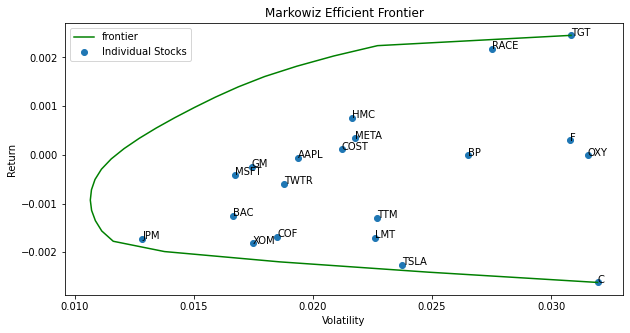

In [42]:
plt.figure(figsize=(10,5))

# plot frontier
plt.plot(frontier,
         return_range,
         label='frontier',
         color = 'green')
# plot stock plot
plt.scatter(stock_matrix['log return volatility'],
            stock_matrix['mean log return'],
            label='Individual Stocks')
# add annotation to stock
for i, stock in enumerate(stocks):
    plt.annotate(stock, (volatility[i], mean_ret[i]))
    
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Markowiz Efficient Frontier')
plt.legend()


# Plot Markowiz Efficient Frontier with our 3 portfolio

In [43]:
Portfolios = {'Eqal':equl_weigh_ret,
              'Min var':min_var_ret,
              'Max Sharpe': max_sharpe_ret}
Portfolios = pd.DataFrame(Portfolios)
Portfolios

Eqal   Min var  Max Sharpe
Date                                      
2022-07-05 -0.002340 -0.025223    0.012698
2022-07-06 -0.003081  0.011429   -0.005148
2022-07-07  0.026849  0.004165    0.032133
2022-07-08 -0.002690 -0.005551   -0.017660
2022-07-11 -0.024649 -0.017063   -0.093478
...              ...       ...         ...
2022-09-26 -0.015952 -0.008114   -0.000660
2022-09-27  0.000728 -0.007823    0.018161
2022-09-28  0.022884  0.010797    0.023325
2022-09-29 -0.026504 -0.021315   -0.036927
2022-09-30 -0.012849 -0.008142    0.008377

[63 rows x 3 columns]

In [44]:
std = Portfolios.std()
mean = Portfolios.mean()

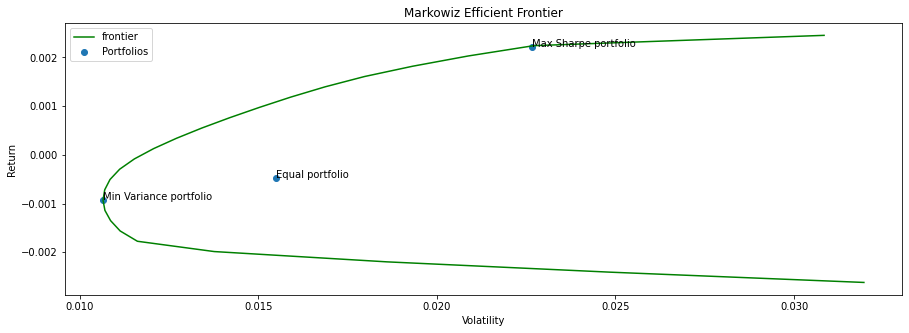

In [45]:
plt.figure(figsize=(15,5))

# plot frontier
plt.plot(frontier,
         return_range,
         label='frontier',
         color = 'green')
# plot stock plot
plt.scatter(std,
            mean,
            label='Portfolios')
for i, stock in enumerate(['Equal portfolio','Min Variance portfolio','Max Sharpe portfolio']):
    plt.annotate(stock, (std[i], mean[i]))
    
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Markowiz Efficient Frontier')
plt.legend()

# Compare holding return for 3 Portfolio

Text(0.5, 1.0, 'Compare holding return for 3 Portfolio add all stocks')

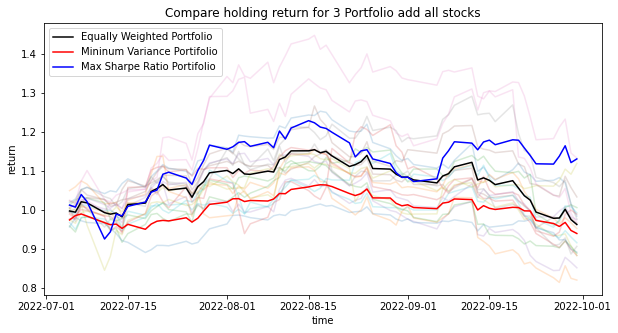

In [46]:
plt.figure(figsize=(10,5))
for s in log_ret.columns:
    plt.plot((log_ret[s] + 1).cumprod(),
             alpha = 0.2)

plt.plot((equl_weigh_ret + 1).cumprod(),
          color = 'black',
          label = 'Equally Weighted Portfolio')

plt.plot((min_var_ret + 1).cumprod(),
          color = 'red',
          label = 'Mininum Variance Portifolio')

plt.plot((max_sharpe_ret + 1).cumprod(),
          color = 'blue',
          label = 'Max Sharpe Ratio Portifolio')

plt.legend()
plt.xlabel('time')
plt.ylabel('return')
plt.title('Compare holding return for 3 Portfolio add all stocks')

# Plot a comparison in holding return

Text(0.5, 1.0, 'Holding Return in 3 Portfolio')

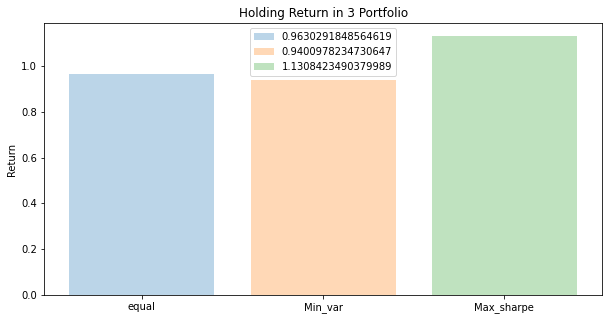

In [47]:
plt.figure(figsize=(10,5))
one = ['equal','Min_var','Max_sharpe']
two = [(equl_weigh_ret + 1).cumprod().tail(1)[0],
       (min_var_ret + 1).cumprod().tail(1)[0],
       (max_sharpe_ret + 1).cumprod().tail(1).values[0]]

for a,b in zip(one,two):
    plt.bar(a,
            b,
            label = b,
            alpha = 0.3)
plt.legend()
plt.ylabel('Return')
plt.title('Holding Return in 3 Portfolio')

# Plot comparison in Volatility

Text(0.5, 1.0, 'Volatility in 3 Portfolio')

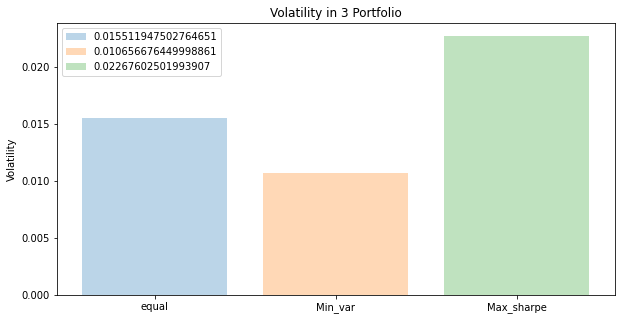

In [48]:
plt.figure(figsize=(10,5))
one1 = [equl_weigh_ret.std(),
        min_var_ret.std(),
        max_sharpe_ret.std()]
two2 = ['equal','Min_var','Max_sharpe']

for a,b in zip(two2,one1):
    plt.bar(a,
            b,
            label = b,
            alpha = 0.3)
plt.legend()
plt.ylabel('Volatility')
plt.title('Volatility in 3 Portfolio')